In [1]:
# unzip out data
import zipfile
import os
import shutil

if os.path.exists("ml-latest-small"):
    shutil.rmtree("ml-latest-small")
    
with zipfile.ZipFile("ml-latest-small.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
    
os.listdir("ml-latest-small/")

['tags.csv', 'README.txt', 'ratings.csv', 'movies.csv', 'links.csv']

# Let's do simple EDA (not very deep)

In [32]:
import pandas as pd
import numpy as np
from scipy import sparse
import re

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/kinetik/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
tags = pd.read_csv("ml-latest-small/tags.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
links = pd.read_csv("ml-latest-small/links.csv")

# Let's see what data do we have for ratings (target values)

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
print("Shape before dedupl {}".format(ratings.shape))
ratings.drop_duplicates(['userId', 'movieId'], inplace=True)
print("Shape after dedupl {}".format(ratings.shape))

Shape before dedupl (100836, 4)
Shape after dedupl (100836, 4)


In [6]:
aggreg = ratings.groupby("userId")['movieId'].count()
print("Minimum ratings per user mean: {} max: {} min: {}".format(aggreg.mean(), aggreg.max(), aggreg.min()))

Minimum ratings per user mean: 165.30491803278687 max: 2698 min: 20


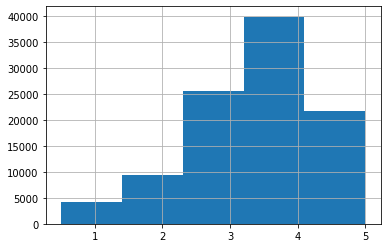

In [7]:
ratings['rating'].hist(bins=5)

# Some research over movies and tags

In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
movies.shape

(9742, 3)

In [10]:
movies['year'] = movies['title'].apply(lambda x: re.findall("(?=.*\((\d+)\))", x)[0] if len(re.findall("(?=.*\((\d+)\))", x)) > 1 else None)
movies['year'].value_counts()

2002    311
2006    295
2001    294
2007    284
2000    283
2009    282
2004    279
2003    279
2014    278
1996    276
2015    274
2005    273
2008    269
1999    263
1997    260
1995    259
1998    258
2011    254
2010    247
2013    239
1994    237
2012    233
2016    218
1993    198
1992    167
1988    165
1987    153
1990    147
2017    147
1991    147
       ... 
1941     18
1945     17
1944     16
1937     16
1952     16
1938     15
1931     14
1935     13
1933     12
1934     11
1943     10
1932      9
1927      7
1924      5
1930      5
1926      5
1925      4
1928      4
1916      4
1923      4
1929      4
1920      2
1908      1
1917      1
1915      1
1922      1
1902      1
1919      1
1903      1
1921      1
Name: year, Length: 106, dtype: int64

In [11]:
genres = {}
counter = 0
for i in range(len(movies)):
    spls = movies.loc[i, 'genres'].split("|")
    for genre in spls:
        if genre in genres:
            continue
        genres[genre] = counter
        counter += 1

In [12]:
print("Всего жанров: {}".format(len(genres)))

Всего жанров: 20


In [13]:
movies['century'] = movies['year'].apply(lambda x: int(x) // 1000 if x else None)
movies['decade'] = movies['year'].apply(lambda x: int(x) // 100 % 10 if x else None)
movies.head()

,movieId,title,genres,year,century,decade
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,1.0,9.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,1.0,9.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,1.0,9.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,1.0,9.0
4,5,Father of the Bride Part II (1995),Comedy,1995,1.0,9.0


In [14]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [15]:
# Too small, let's skip it
tags.shape

(3683, 4)

In [16]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


# So we won't use text features from imdb and from tags data

In [ ]:
#Summary may be gotten using. But we don't have enough time
import requests 
import lxml.html
import pickle
from tqdm import tqdm_notebook

def get_summary(id_val):
    hxs = lxml.html.document_fromstring(requests.get("http://www.imdb.com/title/"+id_val).content)
    try:
        return hxs.xpath('//*[@id="titleStoryLine"]/div[1]/p/span')[0].text.strip()
    except IndexError:
        return ""
    
summaries = {}
for i in tqdm_notebook(range(len(links))):
    link = str(links.loc[i, "imdbId"])
    link = "tt" + "0" * (7-len(link)) + link
    summaries[links.loc[i, "imdbId"]] = get_summary(link)
    
with open("desciptions.pkl", "wb") as f:
    pickle.dump(summaries, f)

# Simple modeling

In this research we are going to compare a set of different approaches to our problem. To begin we should set up a baseline (conctant algorithm). This is just a proportion

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
#Manual test-train split to adjust to have 10 points for each user_id in test
train = []
test = []
grouped_data = ratings.groupby("userId")
for group in grouped_data.groups:
    wrk = grouped_data.get_group(group)
    tmp = wrk.sample(max(10, int(0.4*len(wrk))))
    test.append(tmp)
    train.append(wrk[~wrk['movieId'].isin(set(tmp["movieId"]))])
X_train = pd.concat(train)
X_test = pd.concat(test)

In [20]:
# split into validation and test parts
outer_test = []
prepared_test = []
grouped_test = X_test.groupby("userId")
for group in grouped_test.groups:
    wrk = grouped_test.get_group(group)
    tmp = wrk.sample(10)    
    outer_test.append(tmp)
    prepared_test.append(wrk[~wrk['movieId'].isin(set(tmp["movieId"]))])
X_test = pd.concat(outer_test)
X_valid = pd.concat(prepared_test)

# Baseline

In [30]:
X_valid['Baseline_prediction'] = X_train['rating'].mean()
np.sqrt(np.mean((X_valid['rating'] - X_valid['Baseline_prediction'])**2))

1.0389182679833835

In [31]:
X_test['Baseline_prediction'] = X_train['rating'].mean()

# Userbased CF modeling

User-based collaborative filtering represents each user as a vector of items he or she liked. We need to fill empty value, there are different strategies, but we are going to use item-mean strategy for not to think about empty values on the prediction phase

In [21]:
# CF over users
from sklearn.metrics.pairwise import cosine_similarity
user2item = pd.pivot_table(X_train, values='rating',index='userId',columns='movieId') / 5
user2item.fillna(user2item.mean(axis=0), inplace=True)

In [22]:
user2item.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,189713,190207,190209,190215,190219,191005,193571,193581,193583,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.793548,0.7,0.800000,0.42,0.621429,0.800000,0.642424,0.466667,0.633333,0.7075,...,0.5,0.3,0.8,0.3,0.2,0.9,0.8,0.8,0.7,0.8
2,0.793548,0.7,0.656667,0.42,0.621429,0.792424,0.642424,0.466667,0.633333,0.7075,...,0.5,0.3,0.8,0.3,0.2,0.9,0.8,0.8,0.7,0.8
3,0.793548,0.7,0.656667,0.42,0.621429,0.792424,0.642424,0.466667,0.633333,0.7075,...,0.5,0.3,0.8,0.3,0.2,0.9,0.8,0.8,0.7,0.8
4,0.793548,0.7,0.656667,0.42,0.621429,0.792424,0.642424,0.466667,0.633333,0.7075,...,0.5,0.3,0.8,0.3,0.2,0.9,0.8,0.8,0.7,0.8
5,0.800000,0.7,0.656667,0.42,0.621429,0.792424,0.642424,0.466667,0.633333,0.7075,...,0.5,0.3,0.8,0.3,0.2,0.9,0.8,0.8,0.7,0.8


In [23]:
#We are creating similarities matrix
similarities = cosine_similarity(user2item)
np.fill_diagonal(similarities, 0)
similarities = pd.DataFrame(similarities, index=user2item.index, columns=user2item.index)
similarities.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.999073,0.998411,0.998109,0.998999,0.998387,0.998535,0.999014,0.999023,0.998362,...,0.998998,0.998845,0.996397,0.998888,0.998753,0.997994,0.998515,0.996588,0.999083,0.997651
2,0.999073,0.000000,0.999299,0.998872,0.999872,0.999212,0.999376,0.999851,0.999862,0.999204,...,0.999827,0.999674,0.997453,0.999758,0.999606,0.998855,0.999386,0.997608,0.999933,0.998483
3,0.998411,0.999299,0.000000,0.998227,0.999229,0.998603,0.998755,0.999230,0.999241,0.998581,...,0.999210,0.999053,0.996892,0.999137,0.998985,0.998150,0.998776,0.997028,0.999305,0.997866
4,0.998109,0.998872,0.998227,0.000000,0.998771,0.998157,0.998415,0.998824,0.998817,0.998296,...,0.998749,0.998644,0.996474,0.998702,0.998645,0.997851,0.998398,0.996524,0.998900,0.997350
5,0.998999,0.999872,0.999229,0.998771,0.000000,0.999169,0.999312,0.999771,0.999792,0.999133,...,0.999764,0.999591,0.997399,0.999685,0.999512,0.998803,0.999338,0.997538,0.999864,0.998413


In [24]:
def predict_rating(userId, movieId):
    if movieId not in user2item.columns:
        return 4
    indexes = similarities.loc[userId, :].argsort()[::-1][:30].index
    return user2item.loc[indexes, movieId].mean()*5

In [25]:
predictions = []
for i in tqdm_notebook(X_valid.index):
    predictions.append(predict_rating(X_valid.loc[i, 'userId'], X_valid.loc[i, 'movieId']))
X_valid['CF_prediction'] = predictions

In [26]:
# Quality of such a simple CF seems to be very poor. Let's try more complicated approach
np.sqrt(np.mean((X_valid['rating'] - X_valid['CF_prediction'])**2))

0.9961293288055733

In [27]:
predictions = []
for i in tqdm_notebook(X_test.index):
    predictions.append(predict_rating(X_test.loc[i, 'userId'], X_test.loc[i, 'movieId']))
X_test['CF_prediction'] = predictions

In [28]:
X_test.head()

,userId,movieId,rating,timestamp,CF_prediction
207,1,3247,3.0,964983108,3.013333
161,1,2492,4.0,965719662,3.000000
14,1,235,4.0,964980908,3.750000
215,1,3450,5.0,964981144,3.398718
146,1,2291,5.0,964983664,3.729000


We see that CF solution is better, than our baseline in a sense of RMSE measure (0.99 vs 1.03)

# Let's compare simple CF solution with SVD model

In [33]:
sparse_uid_mapping = {uid: idval for idval, uid in enumerate(ratings['userId'].unique())}
sparse_mid_mapping = {mid: idval for idval, mid in enumerate(ratings['movieId'].unique())}

train_mx = np.zeros((len(sparse_uid_mapping), len(sparse_mid_mapping)))
for i in X_train.index:
    train_mx[sparse_uid_mapping[X_train.loc[i, 'userId']], sparse_mid_mapping[X_train.loc[i, 'movieId']]] = X_train.loc[i, 'rating']
train_sparse = sparse.csr_matrix(train_mx)

In [34]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(train_sparse, k=300)
sigma_diag_matrix=np.diag(sigma)

ratings_pred = np.dot(np.dot(U, sigma_diag_matrix), Vt)

In [35]:
predictions = []
for i in tqdm_notebook(X_valid.index):
    predictions.append(ratings_pred[sparse_uid_mapping[X_valid.loc[i, 'userId']],
                                    sparse_mid_mapping[X_valid.loc[i, 'movieId']]])
X_valid['SVD_prediction'] = predictions
np.sqrt(np.mean((X_valid['rating'] - X_valid['SVD_prediction'])**2))

3.609467458499381

In [36]:
predictions = []
for i in tqdm_notebook(X_test.index):
    predictions.append(ratings_pred[sparse_uid_mapping[X_test.loc[i, 'userId']],
                                    sparse_mid_mapping[X_test.loc[i, 'movieId']]])
X_test['SVD_prediction'] = predictions

It seems, that Pure SVD solution wors worst, than baseline. So it should be finetuned. We see, that matrix decomposition techniques

# Let's compare simple CF solution with LightFm solution

We are going to try to use one of the most powerfull today's technique - lightfm to introduce some features of out items

In [74]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

sparse_uid_mapping = {uid: idval for idval, uid in enumerate(ratings['userId'].unique())}
sparse_mid_mapping = {mid: idval for idval, mid in enumerate(movies['movieId'].unique())}

train_mx = np.zeros((len(sparse_uid_mapping), len(sparse_mid_mapping)))
for i in X_train.index:
    if X_train.loc[i, 'rating'] > 3:
        score = 1
    elif X_train.loc[i, 'rating'] == 3:
        score = 0
    else:
        score = -1
    train_mx[sparse_uid_mapping[X_train.loc[i, 'userId']], sparse_mid_mapping[X_train.loc[i, 'movieId']]] = score
valid_mx = np.zeros((len(sparse_uid_mapping), len(sparse_mid_mapping)))
for i in X_valid.index:
    if X_valid.loc[i, 'rating'] > 3:
        score = 1
    elif X_valid.loc[i, 'rating'] == 3:
        score = 0
    else:
        score = -1
    valid_mx[sparse_uid_mapping[X_valid.loc[i, 'userId']], sparse_mid_mapping[X_valid.loc[i, 'movieId']]] = score

train_sparse = sparse.csr_matrix(train_mx)
valid_sparse = sparse.csr_matrix(valid_mx)

In [75]:
movies.fillna(-1, inplace=True)

century_map = {cent: len(genres) + idval for idval, cent in enumerate(movies['century'].unique())}
decade_map = {dec: len(century_map) + len(genres) + idval for idval, dec in enumerate(movies['decade'].unique())}

item_features = np.zeros((len(sparse_mid_mapping), len(genres) + len(decade_map) + len(century_map)))

for i in movies.index:
    if movies.loc[i, 'century'] == -1:
        item_features[sparse_mid_mapping[movies.loc[i, 'movieId']],
                      century_map[movies.loc[i, 'century']]] = 1
    if movies.loc[i, 'decade'] == -1:
        item_features[sparse_mid_mapping[movies.loc[i, 'movieId']],
                      decade_map[movies.loc[i, 'decade']]] = 1
    for spl in movies.loc[i, 'genres'].split("|"):
        item_features[sparse_mid_mapping[movies.loc[i, 'movieId']],
                     genres[spl]] = 1

In [76]:
model = LightFM(no_components=50)

model.fit(train_sparse,
          item_features=sparse.csr_matrix(item_features),
          epochs=30, num_threads=4)

In [78]:
predictions = []
csr_features = sparse.csr_matrix(item_features)
for i in tqdm_notebook(X_valid.index):
    pre_val = model.predict([sparse_uid_mapping[X_valid.loc[i, 'userId']]],
                            [sparse_mid_mapping[X_valid.loc[i, 'movieId']]],
                            item_features=csr_features)[0]
    if pre_val > 1:
        pre_val = 5.0
    elif pre_val < -1:
        pre_val = 0
    else:
        pre_val = (1 + pre_val) / 2 * 5
    predictions.append(pre_val)
X_valid['LFM_prediction'] = predictions
np.sqrt(np.mean((X_valid['rating'] - X_valid['LFM_prediction'])**2))

1.6349733264872695

In [79]:
X_test.head()

,userId,movieId,rating,timestamp,CF_prediction,Baseline_prediction,SVD_prediction,bin_rating
207,1,3247,3.0,964983108,3.013333,3.504247,-0.091325,1
161,1,2492,4.0,965719662,3.000000,3.504247,-0.002799,1
14,1,235,4.0,964980908,3.750000,3.504247,0.141224,1
215,1,3450,5.0,964981144,3.398718,3.504247,0.014280,1
146,1,2291,5.0,964983664,3.729000,3.504247,-0.078426,1


Finally, we see, that we failed to teach more complicated models. We stop on collaborative filtering